In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-03-02 07:12:26,635 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/newLOO/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
pickle_files

array(['../../results/newLOO/A-crossval-swarm_12-005_2018-01-30_07-25-57.pickle',
       '../../results/newLOO/A-crossval-swarm_51-009_2018-02-04_13-46-32.pickle',
       '../../results/newLOO/A-crossval-swarm_52-001_2018-02-04_13-54-32.pickle',
       '../../results/newLOO/A-crossval-swarm_TB_2018-02-07_01-59-30.pickle',
       '../../results/newLOO/C-crossval-swarm_12-005_2018-01-30_17-00-54.pickle',
       '../../results/newLOO/C-crossval-swarm_51-009_2018-01-30_17-55-55.pickle',
       '../../results/newLOO/C-crossval-swarm_52-001_2018-01-30_17-59-15.pickle',
       '../../results/newLOO/C-crossval-swarm_TB_2018-02-06_17-41-35.pickle',
       '../../results/newLOO/D-crossval-swarm_12-005_2018-02-03_06-45-33.pickle',
       '../../results/newLOO/D-crossval-swarm_51-009_2018-02-03_06-46-14.pickle',
       '../../results/newLOO/D-crossval-swarm_52-001_2018-02-03_06-46-52.pickle',
       '../../results/newLOO/D-crossval-swarm_TB_2018-02-07_03-06-04.pickle',
       '../../results/newLOO

In [3]:
subjects = ['12-005', '51-009', '52-001', 'TB']
models = ['A', 'C', 'D', 'D2', 'E2', 'F2']
assert_params = {
    'amplitude': 2.0,
    'w_scale': 20,
    'w_rot': 0,
    'w_dice': 80
}

In [4]:
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')
drawing_error = {s: {} for s in subjects}
idx_el = {s: None for s in subjects}
for subject in subjects:
    print('Calculating drawing error: %s' % subject)
    X, y = p2pspatial.load_data(os.path.join(rootfolder, subject), subject=subject, electrodes=None,
                                amplitude=assert_params['amplitude'], random_state=42,
                                single_stim=True, verbose=False)
    assert len(X) == len(y) != 0
    for e in X.electrode.unique():
        drawings = y[X['electrode'] == e]
        props = [p2pspatial.imgproc.get_region_props(d['image'], thresh=0.5) 
                 for _, d in drawings.iterrows()]
        area = np.std([p.area for p in props])
        err = np.array([np.rad2deg(np.abs(p.orientation)) for p in props])
        err = np.where(err > 180, 360 - err, err)
        orient = np.std(err)
        major_axis = np.std([p.major_axis_length for p in props])
        minor_axis = np.std([p.minor_axis_length for p in props])
        drawing_error[subject][e] = {'area': area, 'orientation': orient,
                                     'major_axis_length': major_axis,
                                     'minor_axis_length': minor_axis}
    X, y = p2pspatial.transform_mean_images(X, y)
    idx_el[subject] = np.array(X.electrode)

Calculating drawing error: 12-005
Calculating drawing error: 51-009
Calculating drawing error: 52-001
Calculating drawing error: TB


In [5]:
def calc_props_loss(ytyp, specifics, drawing_error, idx_el):
    y_true, y_pred = ytyp
    subject = specifics['subject']
    model = specifics['regressor']
    
    area = []
    orient = []
    for (iyt, yt), (iyp, yp), el in zip(y_true.iterrows(), y_pred.iterrows(), idx_el[subject]):
        if 'image' in yt:
            yt_props = p2pspatial.imgproc.get_region_props(yt['image'], thresh=0.5)
            yt_area = yt_props.area
            yt_orient = yt_props.orientation
        else:
            yt_area = yt['area']
            yt_orient = yt['orientation']

        if 'image' in yp:
            yp_props = p2pspatial.imgproc.get_region_props(yp['image'], thresh=model.img_thresh)
            if yp_props is None:
                yp_area = 0
                yp_orient = 0
            else:
                yp_area = yp_props.area
                yp_orient = yp_props.orientation
        else:
            yp_area = yp['area']
            yp_orient = yp['orientation']
        assert iyt == iyp
        assert el in drawing_error[subject]

        # Calc relative error: area
        err = np.sqrt((yt_area - yp_area) ** 2) / drawing_error[subject][el]['area']
        area.append(err)
        
        # Calc relative error: orientation
        err = np.rad2deg(np.abs(yt_orient - yp_orient))
        err = 360 - err if err > 180 else err
        err = np.sqrt(err ** 2) / drawing_error[subject][el]['orientation']
        orient.append(err)
        
    return {'area': area, 'orientation': orient}

In [6]:
loss = {a: {s: None for s in subjects} for a in models}
for file in pickle_files:
    y_test, y_pred, best_params, specifics = pickle.load(open(file, 'rb'))
    for key, value in six.iteritems(assert_params):
        assert np.isclose(specifics[key], value)
    n_folds = specifics['n_folds']
    assert len(y_pred) == n_folds
    assert len(y_test) == n_folds
    assert len(best_params) == n_folds
    model = specifics['modelname']
    subject = specifics['subject']
    if model not in models:
        print('Model %s found, skip.' % model)
        continue
    if subject not in subjects:
        print('Subject %s found, skip.' % subject)
        continue
    print('Processing Model %s, Subject %s' % (model, subject))
    
    loss[model][subject] = p2pu.parfor(calc_props_loss, zip(y_test, y_pred), 
                                       func_args=[specifics, drawing_error, idx_el])

Processing Model A, Subject 12-005
Processing Model A, Subject 51-009
Processing Model A, Subject 52-001
Processing Model A, Subject TB
Processing Model C, Subject 12-005
Processing Model C, Subject 51-009
Processing Model C, Subject 52-001
Processing Model C, Subject TB
Processing Model D, Subject 12-005
Processing Model D, Subject 51-009
Processing Model D, Subject 52-001
Processing Model D, Subject TB
Processing Model D2, Subject 12-005
Processing Model D2, Subject 51-009
Processing Model D2, Subject 52-001
Processing Model D2, Subject TB
Processing Model E2, Subject TB
Processing Model F2, Subject TB


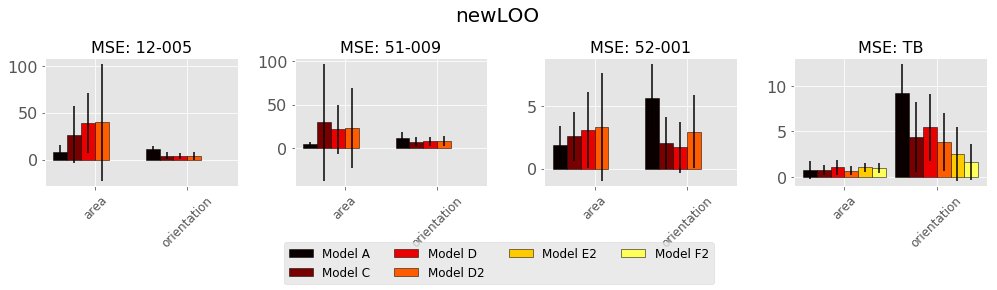

In [7]:
cols = ['area', 'orientation']
N = len(cols)
width = 0.3 / N
ind = np.arange(N)

fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 4), sharex=True)
cm = plt.get_cmap('hot')

for ax, subject in zip(axes.ravel(), subjects):
    rects = {}
    for m, model in enumerate(models):
        for c, col in enumerate(cols):
            if not loss[model][subject]:
                continue
            attr = [l[col] for l in loss[model][subject]]
            attr = [item for sublist in attr for item in sublist]
            r = ax.bar(c + m * width, np.mean(attr), width, yerr=np.std(attr), 
                       color=cm(m / len(models)), edgecolor='k', 
                       label='Model %s' % model)
            rects[model] = r[0]
    ax.set_xticks(ind + 0.5 * (len(models) - 1) * width)
    ax.set_xticklabels(cols, rotation=45, ha='center', fontsize=12)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_title('MSE: %s' % subject, fontsize=16)
fig.suptitle(os.path.basename(os.path.dirname(results_dir)), fontsize=20)
fig.legend([rects[m] for m in models if m in rects],
          ['Model ' + m for m in models if m in rects], 
          ncol=4, loc='lower center', fontsize=12)
fig.tight_layout(rect=[0, 0.1, 1, 0.9])
fig.savefig(os.path.join(results_dir, 'mse_props_loss.png'))